# Install Libraries & Dependencies

In [ ]:
pip install scikit-image

In [ ]:
!pip install scikit-image --upgrade


In [ ]:
import os
import numpy as np
import cv2
import glob
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
import zipfile

zip_file_path = '/content/BraTs18.zip'
extract_path = '/content/BraTs18'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/BraTs18


# Data Preprocessing

In [ ]:
images_dir = "/content/BraTs18/brats18/images"
masks_dir = "/content/BraTs18/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/BraTs18/brats18/images/image_1.png', '/content/BraTs18/brats18/images/image_10.png', '/content/BraTs18/brats18/images/image_100.png', '/content/BraTs18/brats18/images/image_1000.png', '/content/BraTs18/brats18/images/image_1001.png', '/content/BraTs18/brats18/images/image_1002.png', '/content/BraTs18/brats18/images/image_1003.png', '/content/BraTs18/brats18/images/image_1004.png', '/content/BraTs18/brats18/images/image_1005.png', '/content/BraTs18/brats18/images/image_1006.png', '/content/BraTs18/brats18/images/image_1007.png', '/content/BraTs18/brats18/images/image_1008.png', '/content/BraTs18/brats18/images/image_1009.png', '/content/BraTs18/brats18/images/image_101.png', '/content/BraTs18/brats18/images/image_1010.png', '/content/BraTs18/brats18/images/image_1011.png', '/content/BraTs18/brats18/images/image_1012.png', '/content/BraTs18/brats18/images/image_1013.png', '/content/BraTs18/brats18/images/image_1014.png', '/content/BraTs18/brats18/images

In [ ]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [ ]:
# Function to load an image as grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

In [ ]:
# Function to normalize an image by scaling pixel values to the range [0, 1]
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0

In [ ]:
# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

In [ ]:
# Function to resize an image to the target size (default 112x112)
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [ ]:
# Function to preprocess the image by normalizing, enhancing contrast, and resizing
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [ ]:
# Shuffle and split the data into training and validation sets (80%/20%)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [ ]:
# Apply preprocessing to training and validation images
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [ ]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

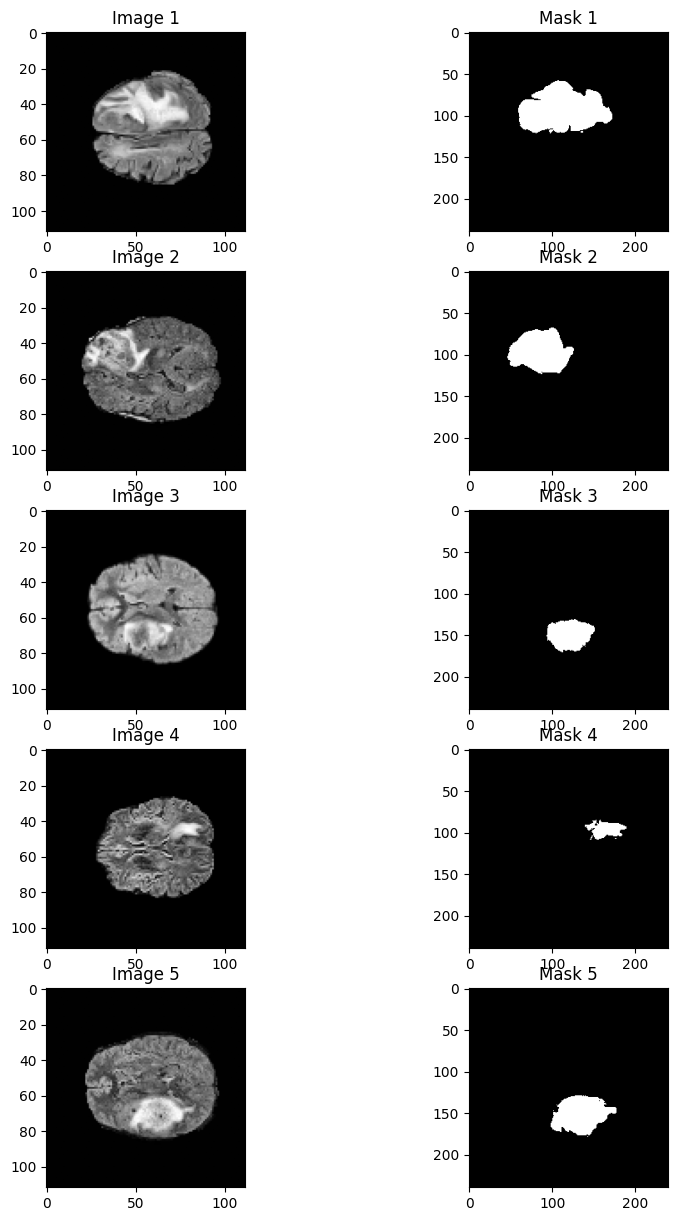

In [ ]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

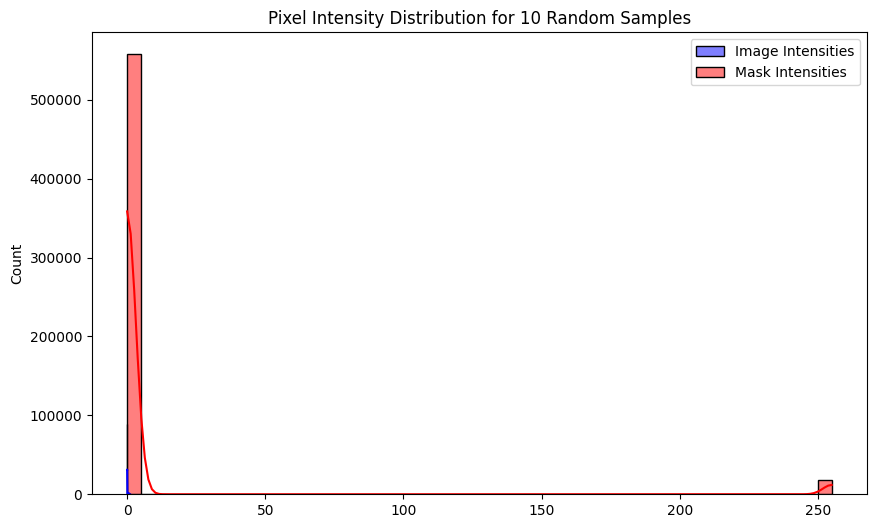

In [ ]:
# Function to plot pixel intensity distribution for a small sample of images and masks
import random
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    sample_indices = random.sample(range(len(images)), sample_size)
    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


# Feature Engineering

In [ ]:
# Function to extract texture features using Grey Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    image = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    return contrast[0, 0], correlation[0, 0], energy[0, 0], homogeneity[0, 0]

features = extract_texture_features(train_images[0])
print("Texture Features (Contrast, Correlation, Energy, Homogeneity):", features)

Texture Features (Contrast, Correlation, Energy, Homogeneity): (np.float64(241.22377734877733), np.float64(0.9616848781183702), np.float64(0.6925881811424732), np.float64(0.7129021436706336))


# **Feature Engineering**

In [ ]:
# Install additional libraries
!pip install shap lime

# Import additional libraries for XAI
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=21ae25a5c2f935a382e2dcf9241debf56336025f6feeb6a7f4bc66528a36caf8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import cv2

## Feature Engineering Functions
def extract_texture_features(image):
    """Extract texture features using GLCM"""
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return np.array([contrast, correlation, energy, homogeneity])

def extract_intensity_features(image):
    """Extract intensity-based features"""
    return np.array([
        np.mean(image),
        np.std(image),
        np.median(image),
        np.min(image),
        np.max(image)
    ])

def extract_edge_features(image):
    """Extract edge-based features"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    return np.array([
        np.mean(magnitude),
        np.std(magnitude),
        np.max(magnitude)
    ])

def extract_all_features(image):
    """Combine all features into one vector"""
    texture = extract_texture_features(image)
    intensity = extract_intensity_features(image)
    edges = extract_edge_features(image)
    return np.concatenate([texture, intensity, edges])

## Data Preparation with Feature Engineering
def prepare_features(images):
    """Extract features for all images"""
    features = []
    for img in images:
        features.append(extract_all_features(img))
    return np.array(features)

# Extract features
train_features = prepare_features(train_images)
val_features = prepare_features(val_images)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

## Transfer Learning Model
def build_transfer_model(input_shape=(112, 112, 1), num_classes=5):
    # Input for images
    img_input = layers.Input(shape=input_shape)

    # Input for engineered features
    feature_input = layers.Input(shape=(12,))  # 12 features from extract_all_features

    # Pre-trained backbone (using EfficientNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(112, 112, 3),
        pooling='avg'
    )

    # Convert grayscale to RGB by repeating channels
    x = layers.Concatenate()([img_input, img_input, img_input])
    x = base_model(x)

    # Combine with engineered features
    x = layers.Concatenate()([x, feature_input])

    # Additional layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[img_input, feature_input], outputs=outputs)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops
import numpy as np

## Feature Engineering Functions
def extract_texture_features(image):
    """Extract texture features using GLCM"""
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return np.array([contrast, correlation, energy, homogeneity])

def extract_intensity_features(image):
    """Extract intensity-based features"""
    return np.array([
        np.mean(image),
        np.std(image),
        np.median(image),
        np.min(image),
        np.max(image)
    ])

def extract_edge_features(image):
    """Extract edge-based features"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    return np.array([
        np.mean(magnitude),
        np.std(magnitude),
        np.max(magnitude)
    ])

def extract_all_features(image):
    """Combine all features into one vector"""
    texture = extract_texture_features(image)
    intensity = extract_intensity_features(image)
    edges = extract_edge_features(image)
    return np.concatenate([texture, intensity, edges])

## Data Preparation with Feature Engineering
def prepare_features(images):
    """Extract features for all images"""
    features = []
    for img in images:
        features.append(extract_all_features(img))
    return np.array(features)

# Extract features
train_features = prepare_features(train_images)
val_features = prepare_features(val_images)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

## Transfer Learning Model
def build_transfer_model(input_shape=(112, 112, 1), num_classes=5):
    # Input for images
    img_input = layers.Input(shape=input_shape)

    # Input for engineered features
    feature_input = layers.Input(shape=(12,))  # 12 features from extract_all_features

    # Pre-trained backbone (using EfficientNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(112, 112, 3),
        pooling='avg'
    )

    # Convert grayscale to RGB by repeating channels
    x = layers.Concatenate()([img_input, img_input, img_input])
    x = base_model(x)

    # Combine with engineered features
    x = layers.Concatenate()([x, feature_input])

    # Additional layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[img_input, feature_input], outputs=outputs)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# ***MODEL***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
import cv2
from skimage.segmentation import slic, mark_boundaries
from tensorflow.keras import models, layers

# التأكد من تثبيت scikit-image
try:
    import skimage
    print("scikit-image is installed.")
except ImportError:
    print("scikit-image is not installed. Installing now...")
    !pip install scikit-image
    import skimage

# تحضير بيانات الاختبار
x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)

# إنشاء val_labels بناءً على val_masks أو قيم افتراضية
try:
    val_labels = np.array([1 if np.any(mask > 0) else 0 for mask in val_masks])
except NameError:
    print("val_masks is not defined. Using zero labels as fallback for validation set.")
    val_labels = np.zeros(len(val_images), dtype=np.int32)

y_test = val_labels.astype(np.int32)

# تطبيع الصور
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min() + 1e-8)

# تحديد مجموعة الاختبار
test_images = x_test[:min(5, len(x_test))]
test_labels = y_test[:min(5, len(y_test))]

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# إنشاء train_labels بناءً على train_masks أو قيم افتراضية
try:
    train_labels = np.array([1 if np.any(mask > 0) else 0 for mask in train_masks])
except NameError:
    print("train_masks is not defined. Using zero labels as fallback for training set.")
    train_labels = np.zeros(len(train_images_array), dtype=np.int32)

# تطبيع بيانات التدريب
train_images_array = (train_images_array - train_images_array.min()) / (train_images_array.max() - train_images_array.min() + 1e-8)
val_images_array = (val_images_array - val_images_array.min()) / (val_images_array.max() - val_images_array.min() + 1e-8)

# نموذج مبسط
def build_simplified_cnn(input_shape=(112, 112, 1), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_2'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# تدريب النموذج المبسط
simplified_model = build_simplified_cnn()
simplified_model.fit(
    train_images_array,
    train_labels,
    validation_data=(val_images_array, val_labels),
    epochs=5,
    batch_size=16,
    verbose=1
)

scikit-image is installed.
Test images shape: (5, 112, 112, 1)
Test labels shape: (5,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


# ***lime***

scikit-image is installed.
Test images shape: (5, 112, 112, 1)
Test labels shape: (5,)
Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

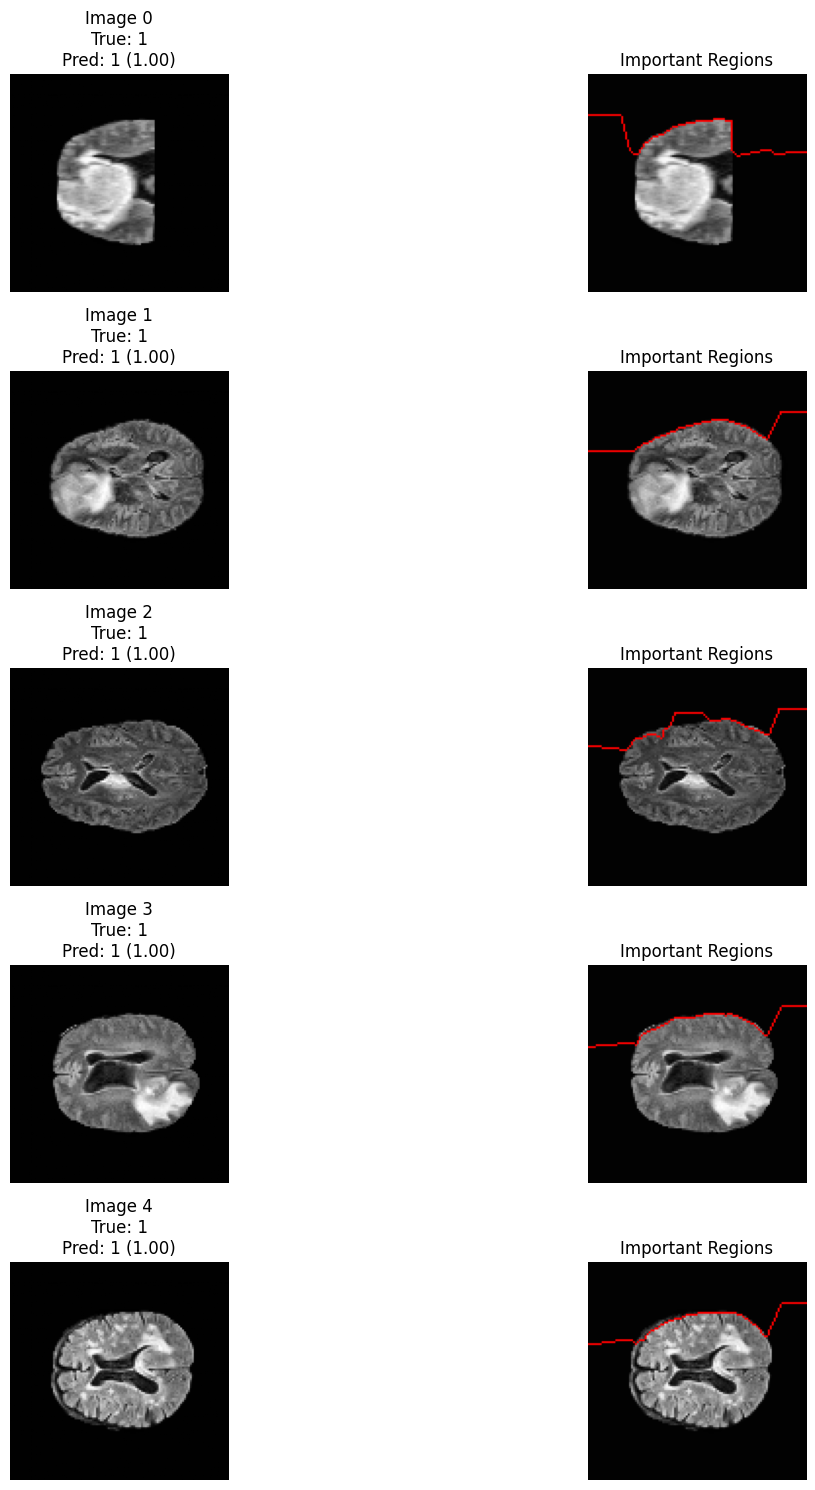

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
import cv2
from skimage.segmentation import slic, mark_boundaries
from tensorflow.keras import models, layers

# التأكد من تثبيت scikit-image
try:
    import skimage
    print("scikit-image is installed.")
except ImportError:
    print("scikit-image is not installed. Installing now...")
    !pip install scikit-image
    import skimage

# تحضير بيانات الاختبار
x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)

# إنشاء val_labels بناءً على val_masks أو قيم افتراضية
try:
    val_labels = np.array([1 if np.any(mask > 0) else 0 for mask in val_masks])
except NameError:
    print("val_masks is not defined. Using zero labels as fallback for validation set.")
    val_labels = np.zeros(len(val_images), dtype=np.int32)

y_test = val_labels.astype(np.int32)

# تطبيع الصور
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min() + 1e-8)

# تحديد مجموعة الاختبار
test_images = x_test[:min(5, len(x_test))]
test_labels = y_test[:min(5, len(y_test))]

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# إنشاء train_labels بناءً على train_masks أو قيم افتراضية
try:
    train_labels = np.array([1 if np.any(mask > 0) else 0 for mask in train_masks])
except NameError:
    print("train_masks is not defined. Using zero labels as fallback for training set.")
    train_labels = np.zeros(len(train_images_array), dtype=np.int32)

# تطبيع بيانات التدريب
train_images_array = (train_images_array - train_images_array.min()) / (train_images_array.max() - train_images_array.min() + 1e-8)
val_images_array = (val_images_array - val_images_array.min()) / (val_images_array.max() - val_images_array.min() + 1e-8)

# نموذج مبسط
def build_simplified_cnn(input_shape=(112, 112, 1), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_2'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# تدريب النموذج المبسط
simplified_model = build_simplified_cnn()
simplified_model.fit(
    train_images_array,
    train_labels,
    validation_data=(val_images_array, val_labels),
    epochs=5,
    batch_size=16,
    verbose=1
)

# دالة model_predict للنموذج المبسط
def model_predict(images):
    processed_images = []
    for img in images:
        if img.ndim == 3:
            if img.shape[-1] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif img.shape[-1] == 1:
                img = img.squeeze()
        img = cv2.resize(img, (112, 112))
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = img[..., np.newaxis]
        processed_images.append(img)

    processed_images = np.array(processed_images)
    return simplified_model.predict(processed_images, verbose=0)

# إعداد LIME
explainer = LimeImageExplainer(random_state=42)

# دالة التجزئة (مع تصحيح channel_axis)
def segment_image(image):
    if image.ndim == 3 and image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    segments = slic(image, n_segments=30, compactness=0.5, sigma=1, start_label=1, channel_axis=None)
    return segments

# عرض النتائج
plt.figure(figsize=(15, 15))
for idx in range(len(test_images)):
    image = test_images[idx]
    image_rgb = np.stack([image.squeeze()] * 3, axis=-1)

    pred_class = -1
    pred_prob = 0.0

    try:
        explanation = explainer.explain_instance(
            image_rgb,
            model_predict,
            top_labels=1,
            hide_color=0,
            num_samples=1000,
            segmentation_fn=segment_image
        )

        pred = model_predict(image[np.newaxis, ...])
        pred_class = np.argmax(pred)
        pred_prob = np.max(pred)

        temp, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=False,
            num_features=10,
            hide_rest=False
        )

        mask = mask.astype(np.uint8)

        if np.all(mask == 0):
            print(f"Warning: Empty mask for image {idx}. Adjusting segmentation.")
            segments = slic(image.squeeze(), n_segments=20, compactness=0.3, sigma=0.5, channel_axis=None)
            temp, mask = explanation.get_image_and_mask(
                pred_class, positive_only=False, num_features=10, hide_rest=False, segmentation_fn=lambda x: segments
            )
            mask = mask.astype(np.uint8)

    except Exception as e:
        print(f"LIME failed for image {idx}: {e}")
        mask = np.zeros_like(image.squeeze(), dtype=np.uint8)
        temp = image.squeeze()

    # عرض الصورة الأصلية
    plt.subplot(len(test_images), 2, idx*2+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Image {idx}\nTrue: {test_labels[idx]}\nPred: {pred_class} ({pred_prob:.2f})')
    plt.axis('off')

    # عرض المناطق المهمة
    plt.subplot(len(test_images), 2, idx*2+2)
    image_for_display = image.squeeze()
    boundary_image = mark_boundaries(image_for_display, mask, color=(1, 0, 0), mode='outer')
    plt.imshow(boundary_image, cmap='gray')
    plt.title('Important Regions' if not np.all(mask==0) else 'No Important Regions')
    plt.axis('off')

plt.tight_layout()
plt.show()

# حفظ النتيجة النهائية
plt.savefig('lime_final_output.png')

# ***SHAP***

In [ ]:
import numpy as np
import cv2
from skimage.measure import label, regionprops
from sklearn.preprocessing import StandardScaler

# دالة معدلة لاستخراج الميزات
def prepare_features(images):
    features = []
    for img in images:
        # إزالة البعد الأخير لو موجود (تحويل من 112x112x1 إلى 112x112)
        if img.ndim == 3:
            img = img.squeeze()

        # التأكد من أن الصورة 2D
        if img.ndim != 2:
            raise ValueError(f"Expected 2D image, got shape {img.shape}")

        # تحويل الصورة إلى binary (ثنائية) لو ما كانتش كده
        binary_img = (img > img.mean()).astype(np.uint8)

        # استخراج الميزات باستخدام regionprops
        labeled_img = label(binary_img)
        props = regionprops(labeled_img)

        if len(props) == 0:
            # لو مفيش مناطق، نرجع قيم افتراضية
            feature = np.zeros(12)
        else:
            region = props[0]
            # الميزات الهندسية
            feature = np.array([
                region.area,
                region.perimeter,
                region.eccentricity,
                region.solidity,
                region.extent,
                region.major_axis_length,
                region.minor_axis_length,
                region.orientation,
                region.moments_hu[0],
                region.moments_hu[1],
                region.moments_hu[2],
                region.moments_hu[3]
            ])
        features.append(feature)

    return np.array(features)

# تطبيع الميزات
scaler = StandardScaler()

Train images min/max: 0.0 1.0
Val images min/max: 0.0 1.0
Background images shape: (20, 112, 112, 1)
Test images shape: (1, 112, 112, 1)
Test images sample min/max: 0.0039370083 0.9848144


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_82
Received: inputs=['Tensor(shape=(20, 112, 112, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_82
Received: inputs=['Tensor(shape=(40, 112, 112, 1))']
  warnings.warn(msg)


SHAP values shape: [(112, 112, 1, 2)]
Number of classes in SHAP values: 1


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_82
Received: inputs=['Tensor(shape=(1, 112, 112, 1))']
  warnings.warn(msg)


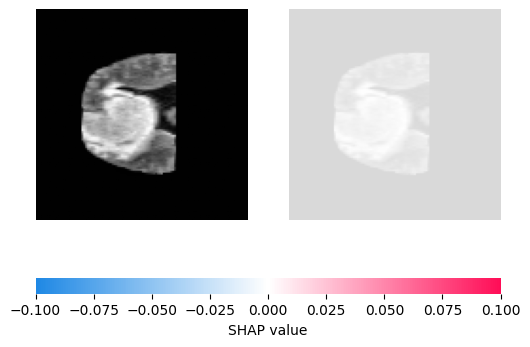

<Figure size 640x480 with 0 Axes>

In [ ]:
# Install and import SHAP
!pip install --upgrade shap
import shap
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Verify data normalization
print("Train images min/max:", train_images_array.min(), train_images_array.max())
print("Val images min/max:", val_images_array.min(), val_images_array.max())

# Prepare a smaller background dataset
background_size = 20
background_indices = np.random.choice(train_images_array.shape[0], background_size, replace=False)
background_images = train_images_array[background_indices]
print("Background images shape:", background_images.shape)

# Select a single test image to explain
num_test_images = 1
test_images = val_images_array[:num_test_images]
print("Test images shape:", test_images.shape)
print("Test images sample min/max:", test_images[0].min(), test_images[0].max())

# Ensure images are in the correct shape for the model
background_images = (background_images - background_images.min()) / (background_images.max() - background_images.min() + 1e-8)
test_images = (test_images - test_images.min()) / (test_images.max() - test_images.min() + 1e-8)
background_images = np.array([cv2.resize(img.squeeze(), (112, 112))[:, :, np.newaxis] for img in background_images])
test_images = np.array([cv2.resize(img.squeeze(), (112, 112))[:, :, np.newaxis] for img in test_images])

# Prepare data for DeepExplainer (only images, since the model doesn't use features directly)
explainer = shap.DeepExplainer(simplified_model, background_images)

# Compute SHAP values for the single test image
shap_values = explainer.shap_values(test_images)
print("SHAP values shape:", [v.shape for v in shap_values])
print("Number of classes in SHAP values:", len(shap_values))

# Visualize SHAP values for the image input
shap.image_plot(shap_values, test_images)

# Save the result
plt.savefig('shap_output.png')

# ***Google DeepDream***


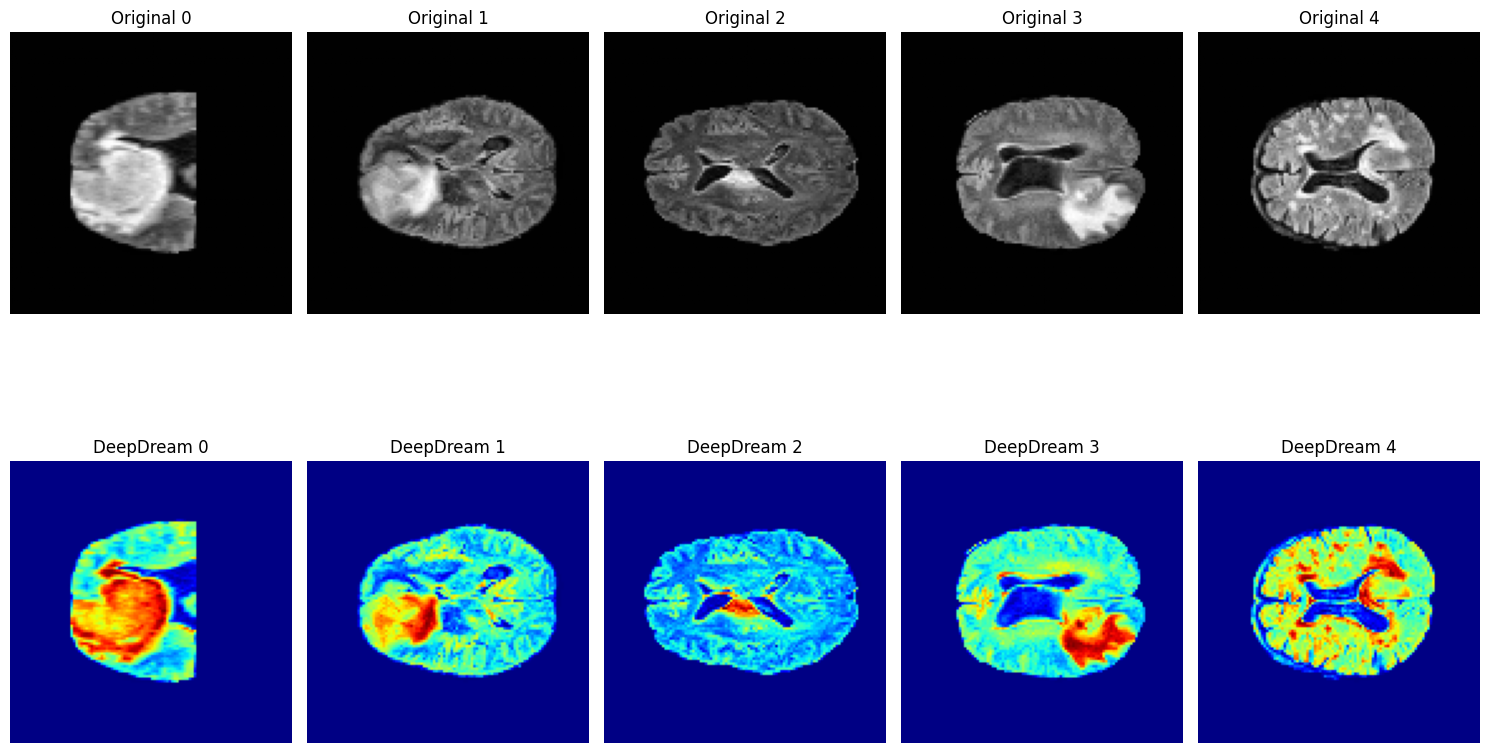

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def deep_dream(model, image, steps=100, step_size=0.01):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            activations = model(image[tf.newaxis, ...])
            loss = tf.reduce_mean(activations)
        gradients = tape.gradient(loss, image)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-7)
        image += gradients * step_size
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image.numpy()

x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)
test_images = x_test[:5]

test_images = (test_images - test_images.min()) / (test_images.max() - test_images.min() + 1e-8)

dreamed_images = []
for img in test_images:
    dreamed_img = deep_dream(simplified_model, img, steps=100, step_size=0.01)
    dreamed_images.append(dreamed_img)

plt.figure(figsize=(15, 10))
for idx in range(5):
    plt.subplot(2, 5, idx+1)
    plt.imshow(test_images[idx].squeeze(), cmap='gray')
    plt.title(f'Original {idx}')
    plt.axis('off')
    plt.subplot(2, 5, idx+6)
    plt.imshow(dreamed_images[idx].squeeze(), cmap='jet')
    plt.title(f'DeepDream {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Test images shape: (2, 112, 112, 1)
Test labels shape: (2,)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_197']]
Received: inputs=Tensor(shape=(1, 112, 112, 1))
  warnings.warn(msg)
<ipython-input-81-b75ed01ae457>:52: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


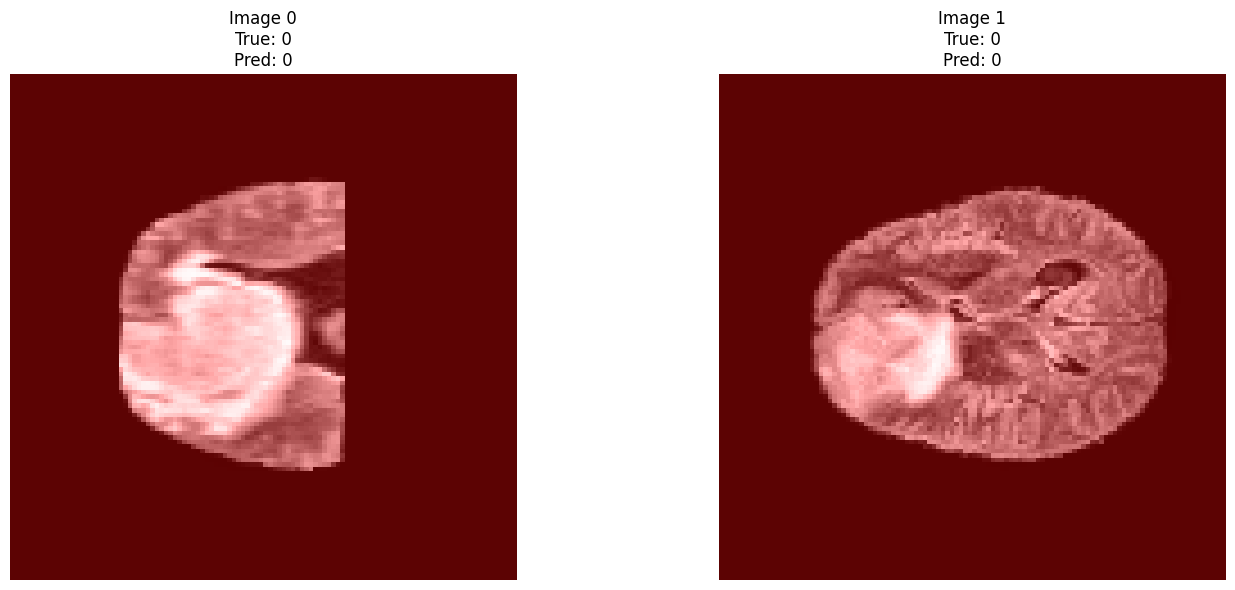

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gradcam(model, img_tensor, class_idx):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            last_conv_layer_name = layer.name
            break
    if not last_conv_layer_name:
        raise ValueError("No convolutional layer found. Check model.summary().")

    grad_model = tf.keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / tf.reduce_max(cam)

    return cam.numpy()

# Prepare data
x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)
y_test = np.array(val_labels).astype(np.int32)

# Select first 5 images
test_images = x_test[:min(2, len(x_test))]
test_labels = y_test[:min(2, len(y_test))]
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

plt.figure(figsize=(15, 6))
for idx in range(len(test_images)):
    img_tensor = test_images[idx:idx+1]
    pred = model.predict(img_tensor, verbose=0)
    class_idx = np.argmax(pred)

    cam = compute_gradcam(model, img_tensor, class_idx)
    cam = cv2.resize(cam, (112, 112))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    np_img = test_images[idx].squeeze()
    np_img = np.expand_dims(np_img, axis=-1)
    overlay = 0.7 * heatmap + np_img

    plt.subplot(1, 2, idx+1)
    plt.imshow(overlay)
    plt.title(f"Image {idx}\nTrue: {test_labels[idx]}\nPred: {class_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()